In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
import time
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import time
%matplotlib inline

## Helper Functions

In [2]:
def imshow(img, size=None):
    if size == None:
        plt.figure(figsize=(14,18))
    else:
        plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def imshow2(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def backgroundExtract(frames):
    avgR, avgG, avgB = None, None, None
    fcnt = 0
    for frame in frames:
        if frame is None:
            break
        frame = cv2.imread(frame)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        B, G, R = cv2.split(frame.astype("float"))
        if avgR is None:
            avgR = R
            avgG = G
            avgB = B
        else:
            avgB = avgB + 1/fcnt*(B - avgB)
            avgG = avgG + 1/fcnt*(G - avgG)
            avgR = avgR + 1/fcnt*(R - avgR)
        
        fcnt += 1

        avg = cv2.merge([avgB, avgG, avgR]).astype('uint8')
        #avg = cv2.cvtColor(avg, cv2.COLOR_HSV2BGR)

    return avg


def robotSegment(img, bg):

    # Color Threshold
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([45, 70, 70])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
    mask_inv = cv2.bitwise_not(mask)

    img_mask = cv2.bitwise_and(img, img, mask=mask_inv)
    bg_mask = cv2.bitwise_and(bg, bg, mask=mask_inv)

    img_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY).astype('float32')
    bg_gray = cv2.cvtColor(bg_mask, cv2.COLOR_BGR2GRAY).astype('float32')

    img_gray = cv2.GaussianBlur(img_gray,(5,5),0)
    bg_gray = cv2.GaussianBlur(bg_gray,(5,5),0)


    sub = np.abs(img_gray - bg_gray)
    
    lower = np.round(np.min(sub))
    upper = np.round(np.max(sub))
    ret, th = cv2.threshold(sub.astype('uint8'), 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([45, 70, 70])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
    mask_inv = cv2.bitwise_not(mask)

    th = cv2.bitwise_and(th, th, mask=mask_inv)

    kernel1 = np.ones((2, 2), np.uint8)
    kernel2 = np.ones((3, 3), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    #erosion = cv2.erode(sub,kernel,iterations = 1)

    # Openning operation to remove noise
    e = cv2.morphologyEx(th, cv2.MORPH_ERODE, kernel1)
    res = cv2.morphologyEx(e, cv2.MORPH_DILATE, kernel2)

    return res


def downsample(img, sample_interval = 10):

    x, y = np.where(img == 255)
    data = []
    for x_loc, y_loc in zip(x, y):
        data.append([x_loc, y_loc])

    sample_interval = sample_interval
    sample_bnd = np.floor(len(data)/sample_interval).astype('int')
    sample_idx = [i*sample_interval for i in range(0, sample_bnd)]
    sample_data = [data[i] for i in sample_idx]

    sample_img = np.zeros(img.shape[:2]).astype('int')
    for x, y in sample_data:
        sample_img[x][y] = 255

    return img

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imshow('labeled.png', labeled_img)
    cv2.waitKey()

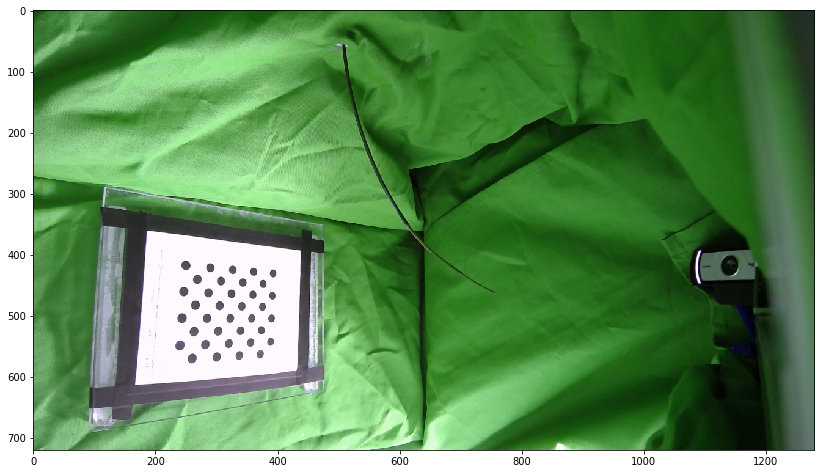

In [3]:
img = cv2.imread('../../data/CTR_Robot/Camera2/cam2_418.png')
imshow(img)

## Threshold Green Background

[[[ 60 255 255]]]


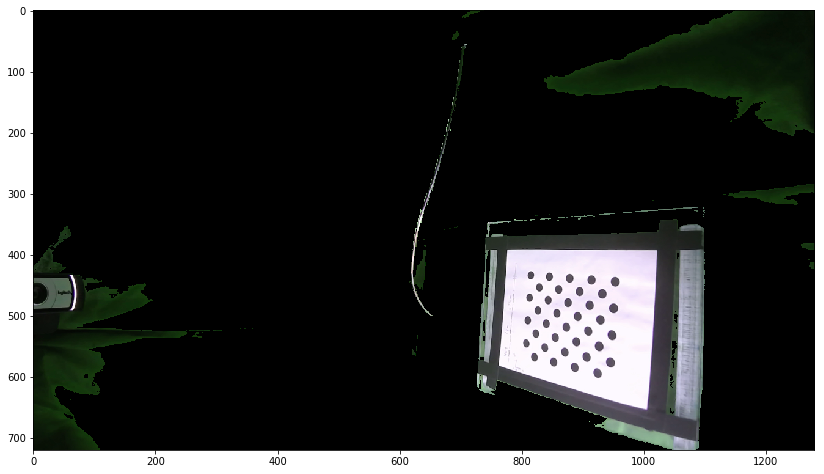

In [5]:
# Locate green color in HSV space
green = np.uint8([[[0,255,0]]])
green_hsv = cv2.cvtColor(green, cv2.COLOR_BGR2HSV)
print(green_hsv)

# Setting boundary in HSV space
lower_bound = np.array([45, 70, 60])
upper_bound = np.array([75, 255, 255])

mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)
res = cv2.bitwise_and(img, img, mask=mask_inv)
imshow(res)

## Edge Detection

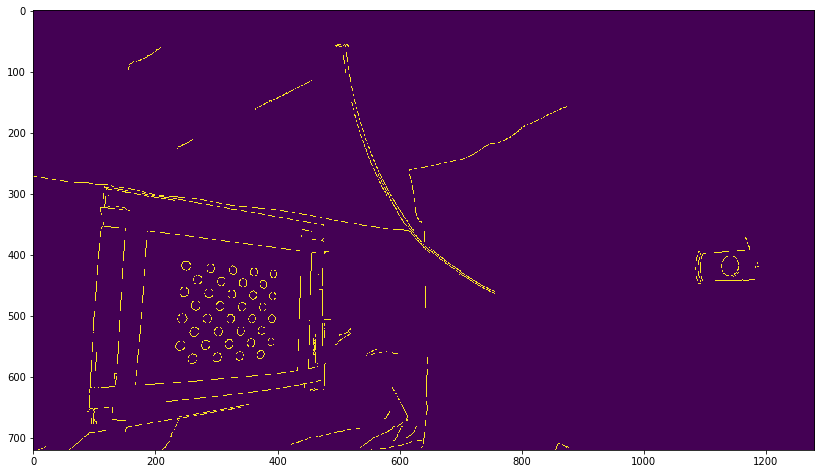

In [186]:
max_lowThreshold = 100
ratio = 3
kernel_size = 3

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.blur(img_gray, (2,2))
edges = cv2.Canny(img_blur, 100, 300)

imshow(edges)

## Background Removal (GM)

In [93]:
#images = glob.glob('../../data/CTR_Robot/Camera2/*.png')

backSub = cv2.createBackgroundSubtractorMOG2(history = 200)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))

for frame in images:
    if frame is None:
        break
    frame = cv2.imread(frame)
    
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([45, 70, 70])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
    mask_inv = cv2.bitwise_not(mask)
    
    
    fgMask = backSub.apply(frame)
    bg = backSub.getBackgroundImage()
    
    fgMask = cv2.bitwise_and(fgMask, fgMask, mask=mask_inv)
    
    
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel)
    
    cv2.imshow('Frame', bg)
    cv2.imshow('FG Mask', fgMask)

    keyboard = cv2.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break
cv2.destroyAllWindows()

In [82]:
images = []
images.append('./bg_res/bg_2_0.png')
for i in range(0, 200):
    dir_ = '../../data/CTR_Robot/Camera2/cam2_' + str(i) + '.png'
    images.append(dir_)

In [77]:
imshow2(frame)

In [37]:
images = glob.glob('./bg_cam1/*.png')

backSub = cv2.bgsegm.createBackgroundSubtractorMOG()

for frame in images:
    if frame is None:
        break
    frame = cv2.imread(frame)

    fgMask = backSub.apply(frame)
    #bg = backSub.getBackgroundImage()
    
    #cv2.imshow('Frame', bg)
    cv2.imshow('FG Mask', fgMask)

    keyboard = cv2.waitKey(500)
    if keyboard == 'q' or keyboard == 27:
        break
    
cv2.destroyAllWindows()

In [48]:
img = cv2.bitwise_or(fg, res1)
imshow2(img)

In [90]:
img = cv2.imread('../../data/CTR_Robot/Camera2/cam2_200.png')
fg = backSub.apply(img)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_bound = np.array([45, 70, 70])
upper_bound = np.array([75, 255, 255])

mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)
fg = cv2.bitwise_and(fg, fg, mask=mask_inv)

imshow2(fg)

## Obtain Background (view 1)

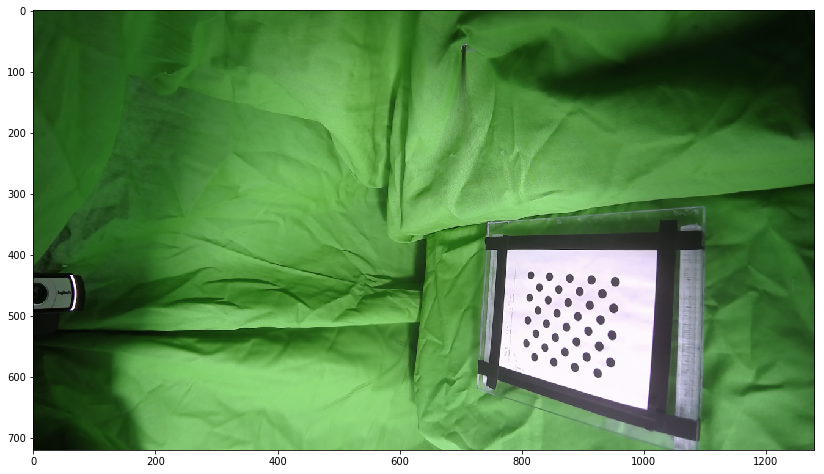

In [2]:
images = glob.glob('./bg_cam1/*.png')
bg1 = backgroundExtract(images)
imshow(bg1)
#cv2.imwrite('bg_1.png', avg)

## Obtain Background (view 2)

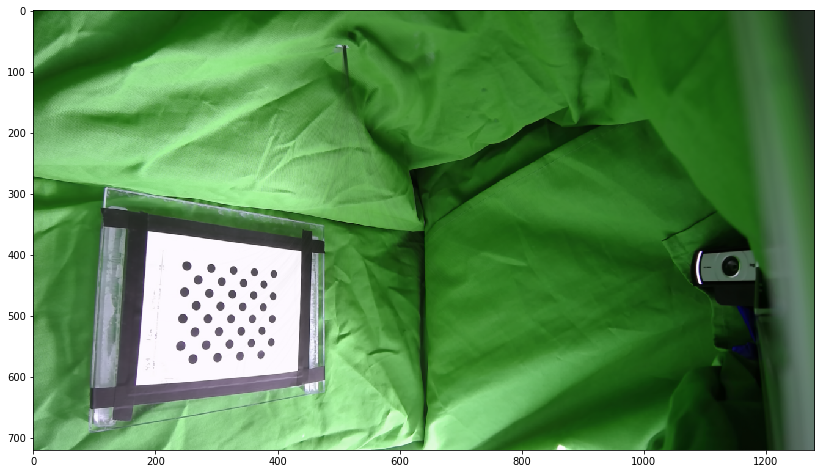

True

In [37]:
images = glob.glob('./bg_cam2/*.png')
bg2 = backgroundExtract(images)
imshow(bg2)
cv2.imwrite('bg_2_t.png', bg2)

## Robot Body Segment (view 1)

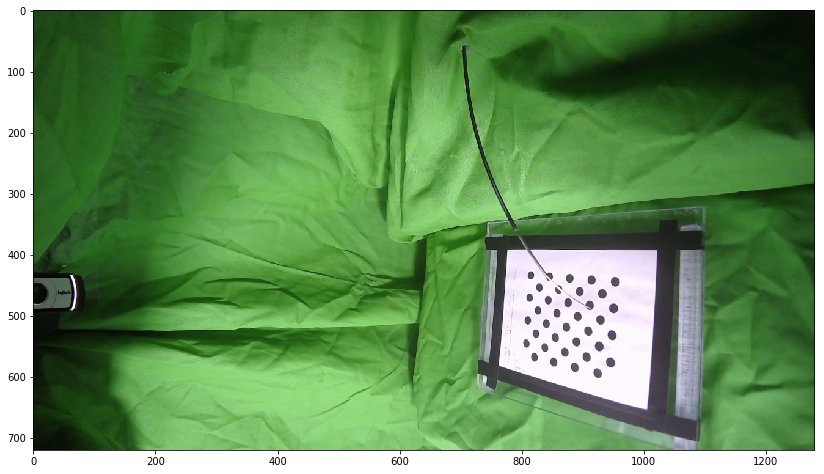

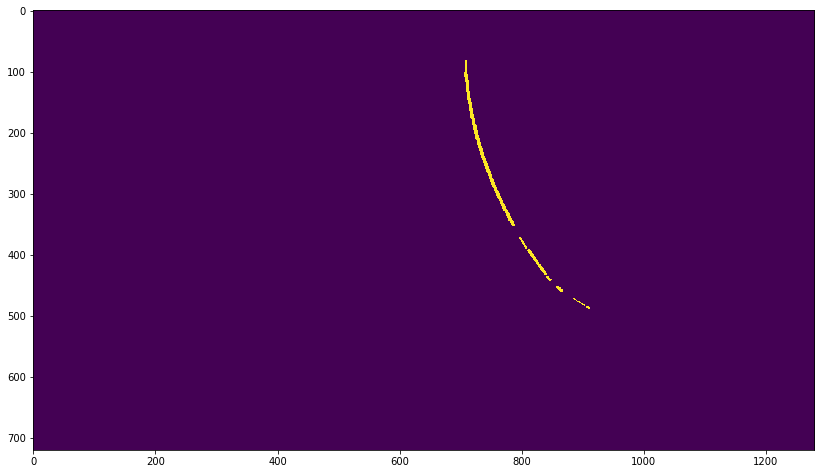

True

In [3]:
img = cv2.imread('../../data/CTR_Robot/Camera1/cam1_47.png')
bg = cv2.imread('./bg_res/bg_1.png')
res1 = robotSegment(img, bg)
imshow(img)
imshow(res1)
cv2.imwrite('./report_result/fail_26.jpg', th)

## Robot Body Segment (view 2)

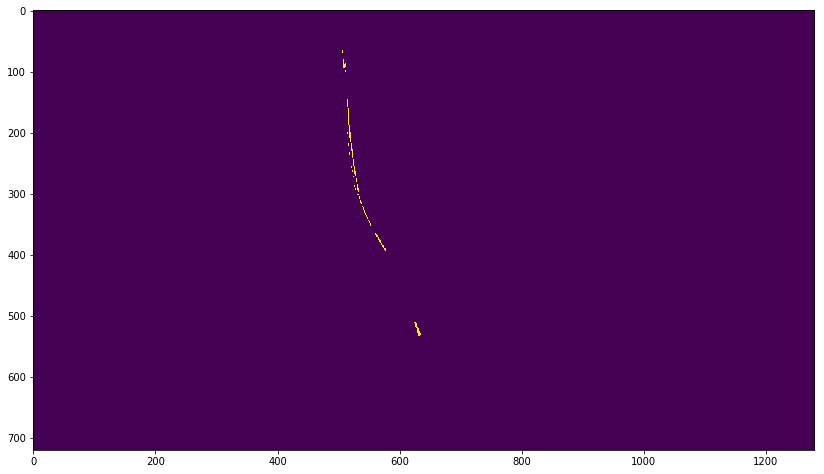

In [21]:
img = cv2.imread('../../data/CTR_Robot/Camera2/cam2_305.png')
bg = cv2.imread('./bg_res/bg_2_6.png')
#res2 = robotSegment(img, bg, 40)
#start = time.time()
res2 = robotSegment(img, bg)
imshow(res2)

## RANSAC Curve Fitting (view 1)

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


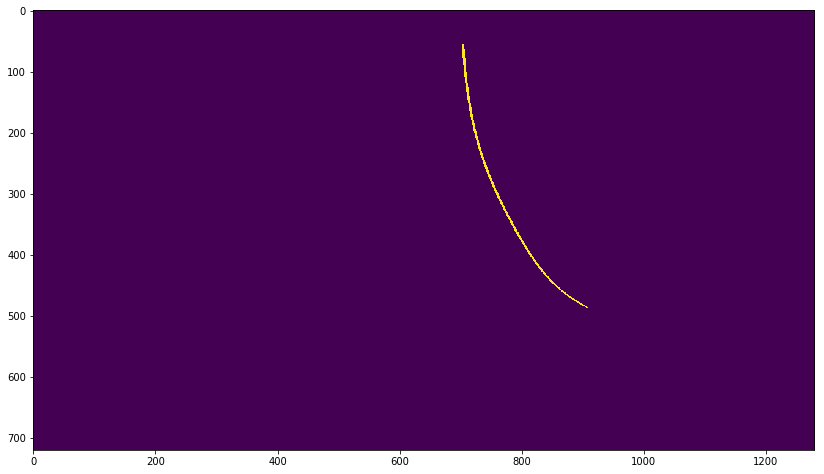

True

In [4]:
# Find all the data points in mask
data = np.where(th==255)
X,y = data[0], data[1]
X = X.reshape(-1,1)

# Create poly feature to fit
poly = PolynomialFeatures(degree = 7, include_bias = True)
X = poly.fit_transform(X)

# Create RANSAC model
ransac = RANSACRegressor(min_samples=0.3, max_trials=100)
ransac.fit(X,y)

# Prepare to plot the curve
#low = min(X[:,1])
low = 55
upper = max(X[:,1])
#upper = 650
point_num = upper - low + 1

x_plot = np.linspace(low, upper, point_num).astype('int')
x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
y_plot = ransac.predict(x_plot_t).astype('int')

curve_fit = np.zeros(th.shape)
for x, y in zip(x_plot, y_plot):
    if x < upper:
        for y_d in range(y-2, y+2):
            curve_fit[x,y_d] = 255

imshow(curve_fit)
#cv2.imwrite('./report_result/fail26.png', curve_fit)

In [26]:
# Find all the data points in mask
data = np.where(th==255)
X,y = data[0], data[1]
X = X.reshape(-1,1)

# Create poly feature to fit
poly = PolynomialFeatures(degree = 7, include_bias = True)
X = poly.fit_transform(X)

# Create RANSAC model
ransac = RANSACRegressor(min_samples=0.3, max_trials=100)
ransac.fit(X,y)

# Prepare to plot the curve
#low = min(X[:,1])
low = 55
upper = max(X[:,1])
#upper = 650
point_num = upper - low + 1

x_plot = np.linspace(low, upper, point_num).astype('int')
x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
y_plot = ransac.predict(x_plot_t).astype('int')

curve_fit = np.zeros(th.shape)
for x, y in zip(x_plot, y_plot):
    if x < upper:
        curve_fit[x,y] = 255

imshow(curve_fit)
#cv2.imwrite('seg140_l.png', curve_fit)

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


## RANSAC Curve Fitting (view 2)

In [ ]:
start = time.time()
# Find all the data points in mask
data = np.where(res2==255)
X,y = data[0], data[1]
X = X.reshape(-1,1)

# Create poly feature to fit
poly = PolynomialFeatures(degree = 7, include_bias = True)
X = poly.fit_transform(X)

# Create RANSAC model
ransac = RANSACRegressor(max_trials=100)
ransac.fit(X,y)

print(time.time() - start)

# Prepare to plot the curve
#low = min(X[:,1])
low = 55
upper = max(X[:,1])
#upper = 412
point_num = upper - low + 1


x_plot = np.linspace(low, upper, point_num).astype('int')
x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
y_plot = ransac.predict(x_plot_t).astype('int')

curve_fit = np.zeros(res2.shape)
for x, y in zip(x_plot, y_plot):
    if x < upper:
        curve_fit[x,y] = 255

imshow(curve_fit)
#cv2.imwrite('seg140_r.png', curve_fit)

## Segmentation Test Platform

In [89]:
#transverse all the frames selected

images = glob.glob('../../data/CTR_Robot/Camera2/*.png')
bg = cv2.imread('bg_2.png')
for fnm in images:
    img = cv2.imread(fnm)
    res = robotSegmentv2(img, bg)
    cv2.imshow('img', img)
    cv2.imshow('seg', res)
    cv2.waitKey(50)
    
cv2.destroyAllWindows()

In [36]:
idx =1
imgs = []
interval = 50
start = list(np.linspace(0, 800, num = 17).astype(int))

for i, ele in enumerate(start[:-1]):
    idx_list = np.linspace(ele, ele+interval, num = interval).astype('int')
    imgs.append([])
    for idx in idx_list:
        imgs[i].append('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')

In [4]:
index = 0
for img_group in imgs:
    bg2 = backgroundExtract(img_group)
    cv2.imwrite('bg_2_' + str(index) + '.png', bg2)
    index += 1

In [131]:
imgs = []
ele = 650
idx_list = np.linspace(ele, ele+interval, num = interval).astype('int')
for idx in idx_list:
    if idx not in range(650, 655):
        if idx not in range(678, 699):
            imgs.append('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')

In [133]:
index = 13
bg2 = backgroundExtract(imgs)
cv2.imwrite('bg_2_' + str(index) + '.png', bg2)

True

## Curve Fit Test

In [230]:
def ransacCurveFit(seg_img, degree = 7, trials = 100, sampleNum = 100):
# Find all the data points in mask
    data = np.where(seg_img==255)
    X,y = data[0], data[1]
    X = X.reshape(-1,1)

    # Create poly feature to fit
    poly = PolynomialFeatures(degree = degree, include_bias = True)
    X = poly.fit_transform(X)

    # Create RANSAC model
    ransac = RANSACRegressor(min_samples=0.3, max_trials=trials)
    ransac.fit(X,y)

    # Prepare to plot the curve
    low = 55
    upper = max(X[:,1])

    point_num = sampleNum


    x_sample = np.linspace(low, upper, point_num)
    x_sample_trans = poly.fit_transform(x_sample.reshape(-1,1))
    y_sample = ransac.predict(x_sample_trans)
    
    pts = np.vstack((y_sample, x_sample))
    return pts

## Pair selection

In [24]:
cv2.namedWindow('img')
cv2.namedWindow('seg')
valid_pair = []
# Robot images
idx_all = list(range(300, 500))
#idx = 300
for idx in idx_all:
    imgL = cv2.imread('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('./bg_res/bg_1.png')
    bg2 = cv2.imread('./bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegmentv2(imgL, bg2)
    segR = robotSegmentv2(imgR, bg1)

    fitL = ransacCurveFit(segL)
    fitR = ransacCurveFit(segR)
    
    
    conImg = np.hstack((imgL, imgR))
    conSeg = np.hstack((fitL, fitR))
    
    
    conImg = cv2.resize(conImg, (1280, 360), interpolation = cv2.INTER_CUBIC)
    conSeg = cv2.resize(conSeg, (1280, 360), interpolation = cv2.INTER_CUBIC)
    
    while True:
        cv2.imshow('img', conImg)
        cv2.imshow('seg', conSeg)
        k = cv2.waitKey(20) & 0xFF
        if k == 27:
            break
        elif k == ord('a'):
            valid_pair.append(idx)
            break
            
cv2.destroyAllWindows()

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

In [27]:
#np.save('evaluation_idx.npy', valid_pair)

In [3]:
indices = np.load('evaluation_idx.npy')

In [28]:
# Label robot joints
class ptCoord:
    def __init__(self):
        self.points = []

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append((x,y))
    
    def reset(self):
        self.points = []
                
ptl = ptCoord()
pt_right = {}

for idx in indices:
    img_right = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')
    
    cv2.namedWindow('imgLeft')
    cv2.setMouseCallback('imgLeft', ptl.click_and_mark)
    cv2.imshow('imgLeft',img_right)
    
    k = cv2.waitKey(0) & 0xFF
    if k == ord('a'):
        pt_right[idx] = ptl.points
        ptl.reset()
    cv2.destroyAllWindows()  

In [25]:
pt_left_real = {}
for key in pt_left.keys():
    if len(pt_left[key]) == 2:
        pt_left_real[key] = pt_left[key]

In [27]:
#np.save('evaluation_pt_left.npy', pt_left_real)

In [ ]:
pt_right_real = {}
for key in pt_right.keys():
    if len(pt_right[key]) == 2:
        pt_right_real[key] = pt_right[key]

In [33]:
right_comp = {}
for key in pt_right_real.keys():
    if key not in pt_left_real:
        right_comp[key] = pt_right_real[key]

In [35]:
#np.save('evaluation_pt_right_comp.npy', right_comp)